In [33]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from spafe.features.mfcc import mfcc, imfcc
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
#from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [34]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization of audio data                            
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [35]:
def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=20, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.01, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=None, high_freq=None, scale='constant', 
              dct_type=2, use_energy=False, lifter=22)
    #print(fs)
    return mfccs

In [36]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T
    return y_train

In [37]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in tqdm(glob.iglob('G:\LibriSpeech\dev-clean\\**/*.flac', recursive=True)):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label      

In [38]:
def s2c(mfcc=False,lpcc=False):
    x,y=[],[]
    data = np.empty([1,148,20])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in tqdm(glob.iglob('G:\LibriSpeech\dev-clean\\**/*.flac', recursive=True)):
        file_name=os.path.basename(file)
        user = file_name.split("-")[0]
        #print(f)
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        #signal = norm_(signal,mean = True)
        #signal = zero_handling(signal)
        
        if mfcc:
            feature = mfcc_(signal,sr)
            #print(feature.shape[0])
        if lpcc:
            feature = lpcc_(signal,sr)   
        #if feature.shape[0]>256:
        
        quotient = int(feature.shape[0]/148)
        end_index = feature.shape[0]-(feature.shape[0]%148)
        r = feature[0:end_index,:]
        re_data = np.reshape(r,(-1,148,20))#b = np.reshape(a, (8, 3, -1))
        data=np.concatenate((data,re_data),axis=0)
        
        re_label = label(user,quotient)
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:,:],data_label

In [39]:
%%time
def write_(x,y):
    with open('mfcc_data.csv', 'a') as mfcc_dataFile:
        writer = csv.writer(mfcc_dataFile)
        writer.writerows(x)
    mfcc_dataFile.close()
    with open('mfcc_label.csv', 'a') as mfcc_labelFile:
        writer = csv.writer(mfcc_labelFile)
        writer.writerows(y)
    mfcc_labelFile.close()

Wall time: 0 ns


In [40]:
%%time
x,y = s2c(mfcc=True,lpcc=False)

#write_(x,y)
print(x.shape,y.shape)


u = np.unique(y)
num_classes = len(u)
#print(u)
d = dict()
for enu,key in enumerate(u,0):
    d[key]=enu
print(d)
for i in range(len(y)):
    y[i] = d[y[i]]

661it [01:13,  9.05it/s]

(2947, 148, 20) (2947,)
{'1272': 0, '1462': 1, '1673': 2, '174': 3, '1919': 4, '251': 5, '422': 6, '652': 7, '777': 8, '84': 9}
Wall time: 1min 13s


In [41]:
X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
print(X.shape)


y_binary = keras.utils.to_categorical(y, num_classes = num_classes)
print(y_binary.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y_binary ,test_size=0.20, shuffle= True)

print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))

(2947, 148, 20, 1)
(2947, 10)
Training shape: (2357, 148, 20, 1), Training label shape : (2357, 10)
Training shape: (590, 148, 20, 1), Training label shape : (590, 10)


In [42]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD


model2 = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x.shape[1],x.shape[2],1)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(64, (3, 3), activation='relu'))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(10, activation='softmax'))
                                                           #optimizer=keras.optimizers.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])
print(model2.summary())#Train and Test The Model


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 146, 18, 32)       320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 144, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 72, 8, 32)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 72, 8, 32)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 70, 6, 64)         18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 68, 4, 64)         36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 34, 2, 64)        

In [43]:
%%time
#history = model2.fit(x_train, y_train, batch_size=16, epochs=200, verbose=1,validation_data=(x_test, y_test))

Wall time: 0 ns


In [44]:
from keras.callbacks import ModelCheckpoint
# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model.weights.best.23_01.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model2.fit(x_train, y_train, batch_size=16, epochs=300, 
                    validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

2357/2357 [==============================] - 40s 17ms/step - loss: 0.1337 - accuracy: 0.9805 - val_loss: 0.1574 - val_accuracy: 0.9644

Epoch 00300: val_loss did not improve from 0.06057


In [45]:
# Loading the model that performed the best on the validation set
model2.load_weights('Model.weights.best.23_01.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model2.evaluate(x_test, y_test, batch_size=16, verbose=1)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

590/590 [==============================] - 2s 3ms/step
Accuracy on test data: 98.14%


In [48]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    #plt.figure(figsize=(12, 8))
    acc = history.history['accuracy']                          # Loss on the training data
    val_acc = history.history['val_accuracy']                  # Loss on the validation data
    epochs = range(1, 301)
    plt.plot(epochs, acc,  label='Training Accuracy')
    plt.plot(epochs, val_acc,  label = 'Validation Accuracy')
    plt.legend()
    plt.show()

def loss_plot(history):
    #plt.figure(figsize=(12, 8))
    loss = history.history['loss']                          # Loss on the training data
    val_loss = history.history['val_loss']                  # Loss on the validation data
    epochs = range(1, 301)
    plt.plot(epochs, loss,  label='Training Loss')
    plt.plot(epochs, val_loss,  label = 'Validation Loss')
    plt.legend()
    plt.show()

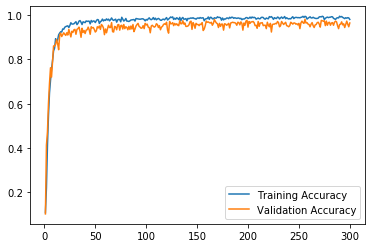

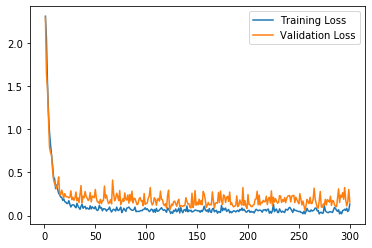

In [49]:
mean = np.mean(history.history['val_accuracy'])
std = np.std(history.history['val_accuracy'])
accuracy_plot(history)
loss_plot(history)